# Missing Persons Reports
### State of the Database
The dataset used and described in this repo is an aggregation of several datasets received from Chicago Police Department via FOIA requests made between January 2021 and April 2023. Each version of the database was requested to include, 
- _"all missing person cases (closed and currently open)"_
- **from 1 January 2000 to the date of the request**,
- as well as several fields related to the missing person (date last seen, age, race, etc.) and CPD's interaction with the report (status, officer arrival time).

In [1]:
import pandas as pd

In [2]:
def load_df(f, cut_year=2023):
    assert '.parquet' in f
    df = pd.read_parquet(f)
    assert 'date_occurred' in df.columns
    return df.loc[df.date_occurred.dt.year < cut_year]

def get_rd_set(df):
    assert 'rd_no' in df.columns
    return set(df.rd_no.unique())

In [4]:
# aggregated missing persons table
mp = load_df("../../US-II-MP/individual/MP_CPD/export/output/mp.parquet")

# version-aggregated mp table before ucr dataset merged
pre_ucrs_mp = pd.read_parquet("../../US-II-MP/individual/MP_CPD/clean/output/mp.parquet", engine='fastparquet')

# supplemental request for records where UCR began as 6050 and was re-classified
# (included in aggregated table)
ucrs = load_df("../../US-II-MP/individual/MP_CPD/ucr-codes/output/ucrs.parquet")

# by version
first = load_df("../../US-II-MP/export/output/versions/first.parquet")
second = load_df("../../US-II-MP/export/output/versions/second.parquet")
third = load_df("../../US-II-MP/export/output/versions/third.parquet")
fourth = load_df("../../US-II-MP/export/output/versions/fourth.parquet")
fifth = load_df("../../US-II-MP/export/output/versions/fifth.parquet")
sixth = load_df("../../US-II-MP/export/output/versions/sixth.parquet")

rds = {
    'first': get_rd_set(first),
    'second': get_rd_set(second),
    'third': get_rd_set(third),
    'fourth': get_rd_set(fourth),
    'fifth': get_rd_set(fifth),
    'sixth': get_rd_set(sixth),
    'ucrs': get_rd_set(ucrs),
    'pre-ucrs-final': get_rd_set(pre_ucrs_mp),
    'final': get_rd_set(mp),
    
}

### Identifying Outcomes
> **What would a missing person returning home / being located safely look like in this dataset?**

A common statement often used to quiet panic about missing persons reports is that a majority are examples of juvenile runaways who ultimately return home safely. 

An update to one FOIA request was made by our investigative partners who noted, _"These records do not include whether or not the person was found or recovered deceased. This information is public and is often relayed by the Chicago Police Department via news affairs regularly. Can you provide an export of the columns that reflect that information?"_

This follow-up question was addressed via a note attached to the dataset, \
"Provided are the RD numbers and current IUCR classifications of incidents originally classified under IUCR code 6050 (MISSING PERSON). 
A case originally classified as MISSING PERSON may have its IUCR code updated to reflect new information: 

for example, the incident's IUCR code may be updated to 
- 6055 (NON-CRIMINAL: FOUND PERSON), 
- 5084 (NON-CRIMINAL: DEATH), 

or a criminal code such as 
- 1790 (CHILD ABDUCTION), 
- 4220 (KIDNAPPING), or 
- 0110 (HOMICIDE: FIRST DEGREE MURDER).

More specific information on missing person recoveries would be captured in individual case report narratives."

This response suggests that - short of requesting the full case report and examining the individual narratives - we can use the UCR code field to extrapolate what happened to the missing person, ie. whether they were found safely or something else occurred.

> Are we sure that using the UCR code field:
> - (a) fully addresses our question?
> - (b) is an accurate interpretation of Illinois Uniform Crime Reporting code definitions?
> 
> How might we verify (a) and (b)?

In [47]:
[col for col in mp.columns if 'ucr' in col]

['current_iucr']

In [48]:
mp.current_iucr.value_counts()

current_iucr
6050    354933
6055        50
1790        14
110         11
1780         4
5084         4
281          4
1791         3
5080         3
5085         2
1562         2
5000         2
4210         2
4220         1
5070         1
5002         1
915          1
4230         1
1563         1
1310         1
486          1
2860         1
2449         1
460          1
266          1
1120         1
1792         1
5091         1
Name: count, dtype: int64

### Who is a 'FOUND PERSON'?

From 1998 to 2012, CPD Directives for Missing Persons Reports came from [General Order G04-05](https://directives.crimeisdown.com/diff/4520df49315b17f77e0146d10e3534bdb9e65ee3/directives/data/a7a57be2-12946bda-6b312-9483-e0c1c4cbac7f5ccf.html). In February 2012, a [Special Order S04-05](https://directives.crimeisdown.com/diff/4520df49315b17f77e0146d10e3534bdb9e65ee3/directives/data/a7a57be2-12946bda-6b312-9484-5aef0923e0dd186a.html) was issued adding some definitions and a prompt to inquire about the missing's age. The Special Order would be more substantially revised in [October 2019](https://directives.crimeisdown.com/diff/e6ce72526cffaf66a2eaf932f0048dff68c6b76b/directives/data/a7a57be2-12946bda-6b312-9484-5aef0923e0dd186a.html) and most recently in [August 2020](https://directives.crimeisdown.com/diff/203606499ca0c8da4c8eb1868afce5785a68a860/directives/data/a7a57be2-12946bda-6b312-9484-5aef0923e0dd186a.html).

The order from 1998 states that, "A Missing/Found Person Case Report (CPD-11.407) will be completed for residents of the City of Chicago and visitors to the City who are missing under unusual circumstances. Complainants who are visitors to the City will be instructed to also report such cases to the local police agency whose jurisdiction covers the missing person's permanent residence."

In both orders, the glossary defines these terms:
- "**Found Person** - An individual of any age who is found and not cognizant of his or her whereabouts and cannot make contact with a responsible person having a concern for his or her welfare. This includes persons who, due to a weakened or impaired physical or mental condition, are unable to contact a responsible person having a concern for their well being."
- "**Located Person** - Any person previously reported missing whose whereabouts are verified."

More details:
- "If the located/returned person was the victim or perpetrator of a crime, or a tender age child, then a district field unit will be dispatched to conduct the preliminary investigation."
- "A.	Members who are notified of a person who has been reported missing and is subsequently located will:
    1.	ensure that the Youth Investigations Division, Missing Persons Section has been notified of the return, and
    2.	complete a Supplementary Report (CPD 11.411-A&B) to the original Missing/Found Person Case Report only in instances where documentation of additional information regarding the circumstances of the return is needed.
        * NOTE:	A located person is not considered to be a found person . A Missing/Found Person Case Report will not be used as a supplementary report.
B.	The location of the person must be verified to complete the investigation.\
C.	The member who discovers the person's location is responsible for notifying the complainant that the missing subject has been located."

### DOJ Investigation
In January 2017, the United States Department of Justice Civil Rights Division and the United States Attorney’s Office Northern District of Illinois [published findings](https://www.justice.gov/d9/chicago_police_department_findings.pdf) from their Investigation of the Chicago Police Department.

In Section IV, titled, "CPD DOES NOT PROVIDE OFFICERS WITH SUFFICIENT DIRECTION, SUPERVISION, OR SUPPORT TO ENSURE LAWFUL AND EFFECTIVE POLICING", part D describes practices around data collection and transparency.
- "Deficiencies in how the City and CPD collect, analyze, and publish data regarding police activities contribute to the Department’s failure to identify and correct unconstitutional policing. These deficiencies also inhibit transparency regarding CPD’s practices. For decades, Chicago has failed to develop a comprehensive, integrated system to track and make public basic information about its police force. Instead, information is siloed, inaccurate, and incomplete. In addition, by failing to analyze and use important data, and by not reporting on that data publicly, the City is missing an opportunity to improve public transparency, and in turn, the relationship between CPD and the public."
- ""

In [22]:
real_mp.status.value_counts()

status
CLOSED NON-CRIMINAL    353891
OPEN ASSIGNED             806
SUSPENDED                 193
OPEN ORIGINAL             146
EX CLEARED CLOSED         140
CLEARED CLOSED             70
CLEARED OPEN                3
OPEN UNASSIGNED             2
EX CLEARED OPEN             1
Name: count, dtype: int64

In [13]:
ucrs.date_occurred.describe()

count                           315
mean     2009-02-02 03:03:31.809523
min             2000-02-17 23:35:00
25%             2005-12-05 19:37:30
50%             2008-08-09 17:00:00
75%             2011-12-28 23:10:30
max             2023-01-24 03:00:00
Name: date_occurred, dtype: object

In [14]:
hist_mp = mp.loc[mp.date_occurred.dt.year < 2023].copy()
mp_rds = set(hist_mp.rd_no.unique())

hist_ucrs = ucrs.loc[ucrs.date_occurred.dt.year < 2023].copy()
ucr_rds = set(hist_ucrs.rd_no.unique())

In [15]:
len(mp_rds)

352712

In [16]:
len(ucr_rds)

313

In [17]:
len(ucr_rds.difference(mp_rds))

199

In [26]:
mp[['fingerprints', 'photo_avail', 'dental_records', 'medical_records']].value_counts()

fingerprints  photo_avail  dental_records  medical_records
N             N            N               N                  178876
              Y            Y               Y                   56025
Y             Y            Y               Y                   47908
N             Y            N               N                   25868
                                           Y                   17686
              N            N               Y                    5975
Y             Y            N               Y                    4577
N             N            Y               Y                    3653
Y             Y            N               N                    2559
N             Y            Y               N                    1899
Y             N            Y               Y                    1846
              Y            Y               N                     910
              N            N               Y                     630
                                           N

In [28]:
mp.loc[(mp.race.isna()) & (mp.sex.isna()), 
    ['fingerprints', 'photo_avail', 'dental_records', 'medical_records']].value_counts()

fingerprints  photo_avail  dental_records  medical_records
N             N            N               N                  1795
              Y            Y               Y                   306
Y             Y            Y               Y                   228
N             Y            N               N                   156
                                           Y                   109
              N            N               Y                    38
Y             Y            N               Y                    28
N             N            Y               Y                    22
Y             Y            N               N                    17
N             Y            Y               N                     7
Y             N            Y               Y                     7
                           N               Y                     5
              Y            Y               N                     5
N             N            Y               N                     4
Y  

<Axes: xlabel='year_occurred'>

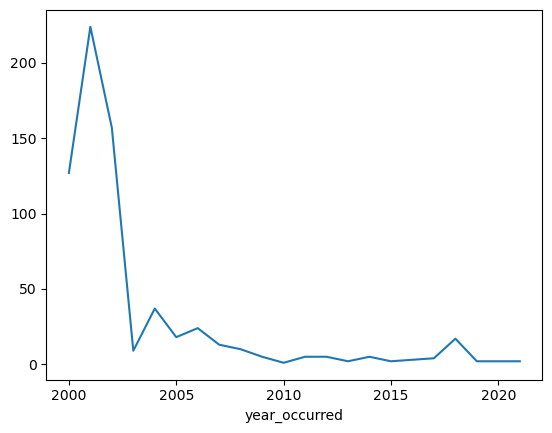

In [34]:
mp.loc[(mp.race.isna()) & (mp.sex.isna()) & 
        (mp.photo_avail == 'Y') & (mp.medical_records=='Y'), 
        'year_occurred'].value_counts().sort_index().plot()

<Axes: xlabel='year_occurred'>

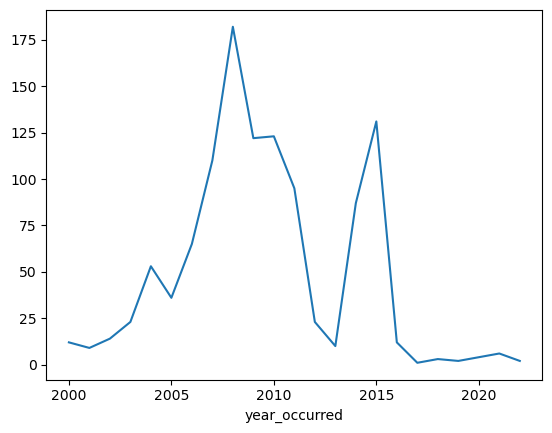

In [36]:
mp.loc[(mp.no_basic_profile), 
        'year_occurred'].value_counts().sort_index().plot()

<Axes: xlabel='year_occurred'>

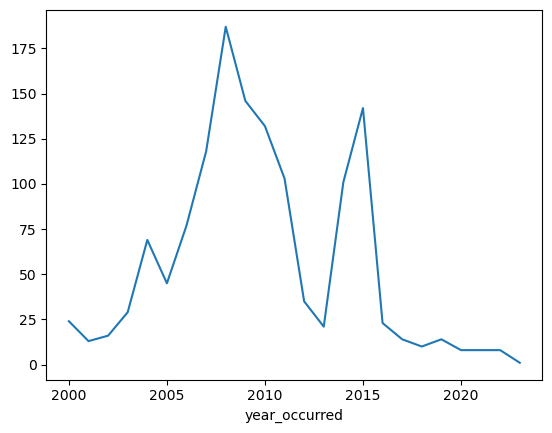

In [39]:
mp.loc[(mp.no_age_data == 1), 
        'year_occurred'].value_counts().sort_index().plot()

In [43]:
mp.loc[(mp.no_age_data == 1), 
    ['fingerprints', 'photo_avail', 'dental_records', 'medical_records']].value_counts()

fingerprints  photo_avail  dental_records  medical_records
N             N            N               N                  1274
              Y            Y               Y                    26
Y             Y            Y               Y                    16
N             Y            N               N                    11
                                           Y                     5
              N            Y               Y                     2
Y             Y            N               N                     2
N             N            N               Y                     1
              Y            Y               N                     1
Y             N            N               N                     1
                           Y               Y                     1
              Y            N               Y                     1
Name: count, dtype: int64

<Axes: xlabel='year_occurred'>

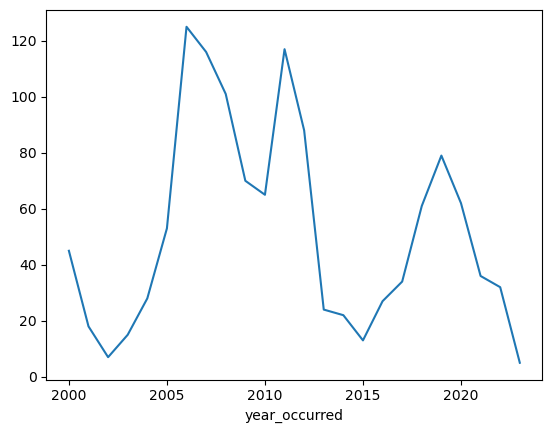

In [46]:
mp.loc[(mp.age_group.str.contains('0-9')) & (mp.date_officer_arrived.isna()), 
        'year_occurred'].value_counts().sort_index().plot()